## Check rounding error of saving pes waveforms as integers

After the results shown in [ZS_EARRAY_TABLE_IO_COMPARISON.ipybn](ZS_EARRAY_TABLE_IO_COMPARISON.ipynb), it is clear that earrays are more efficient and faster to read back from file than tables. Hence, we are interested in saving all waveforms (including ZSWFs) as earrays.

Now, the concern moves to whether it is accurate to save ZS waveforms as integers. For non-ZS waveforms, there is no choice, as they are expressed in ADC counts, which are integers. When they are scaled to PES, however, they become floats, and the rounding error can have an effect in the resolution.

In order to measure the effect, we are going to compare the sum of the rounded samples, with the sum of the non-rounded samples. For that we use the BLR WF before and after applying ZS.

In [ ]:
from __future__ import print_function
import tables as tb
import numpy as np
import time
import wfmFunctions as wfm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
import FEParam as FP
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8) # Bigger plots
%matplotlib inline
%load_ext autoreload
%autoreload 2
print("This notebook has been run last on {} at {}.".format(time.strftime("%d/%m/%Y"),time.strftime("%H:%M:%S")))

In [79]:
try:
    h5f.close()
except:
    pass

In [69]:
h5f      = tb.open_file('/Users/Gonzalo/github/IC/data/ISIDORA1000.h5')
pmtblr   = h5f.root.RD.pmtblr

pmt_adc_ = [19.200523269821286, 18.337220349094959, 18.277890643055709, 20.094008664586799, 19.623449041069801, 18.267600383584281,
            19.062919010617382, 17.392029016798073, 18.334949819343084, 18.462968438179974, 18.634919155741205, 18.112776381185306]

pmt_adc_ = 1.0/np.array(pmt_adc_).reshape(len(pmt_adc_),1)

pmt_adc_ave_ = np.mean(pmt_adc_)

Noise threshold = 0.714242204479 pes


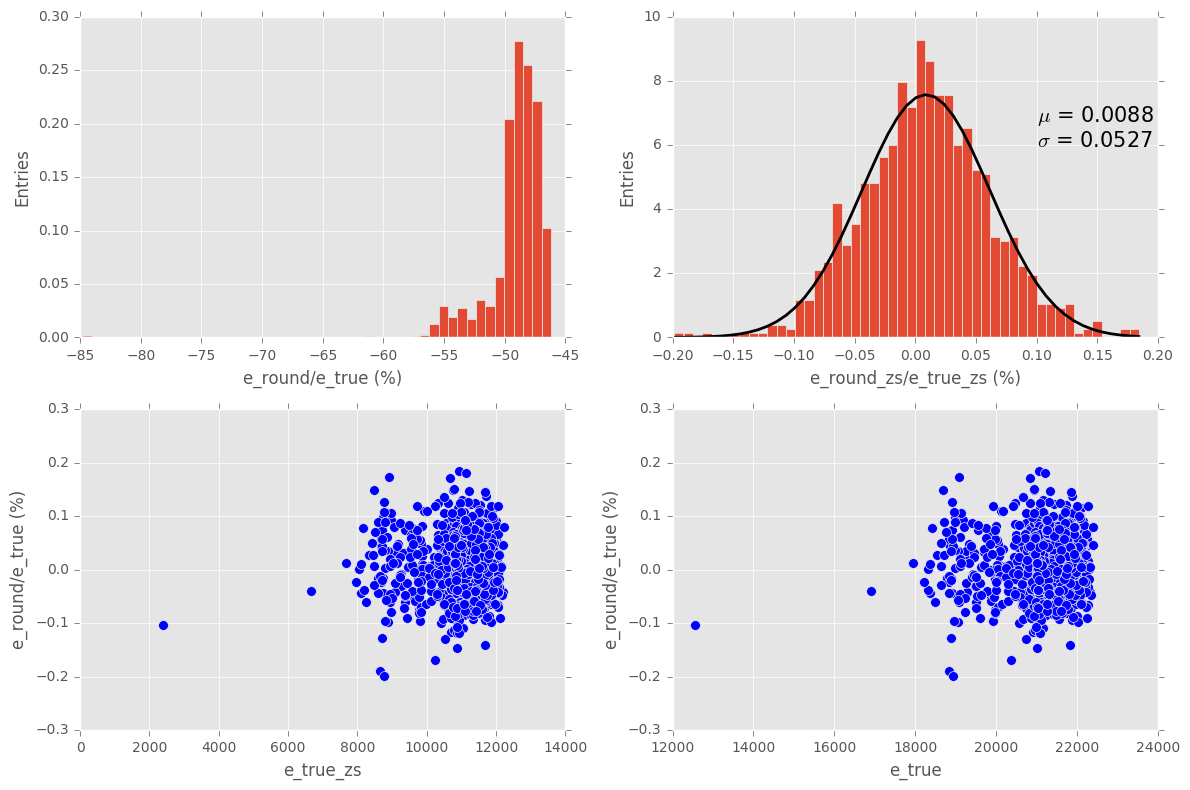

In [78]:
NEVT, NPMT, PMTWL = pmtblr.shape
thrs = 5. * FP.NOISE_ADC * pmt_adc_ave_ * NPMT**0.5
print('Noise threshold = {} pes'.format(thrs))
e_true, e_round = np.empty(NEVT),np.empty(NEVT)
e_true_zs, e_round_zs = np.empty(NEVT),np.empty(NEVT)

for i,evt in enumerate(pmtblr):
    ### BEFORE ZS
    evt_pes = (2500-evt) * pmt_adc_
    evt_pes_true = evt_pes.sum()
    evt_pes_round = np.round(evt_pes).sum()
    
    ### AFTER ZS
    bf = evt_pes.sum(axis=0)
    evt_zs = wfm.noise_suppression(evt_pes.sum(axis=0).reshape(1,PMTWL), thrs)[0]
    evt_zs_true  = evt_zs.sum()
    evt_zs_round = np.round(evt_zs).sum()
    
    e_true[i] = evt_pes_true
    e_round[i] = evt_pes_round
    e_true_zs[i] = evt_zs_true
    e_round_zs[i] = evt_zs_round
#    print( evt_pes_true, evt_pes_round, evt_zs_true, evt_zs_round )

e_ratio    = (e_round/e_true - 1. ) * 100.
e_ratio_zs = (e_round_zs/e_true_zs - 1. ) * 100.

fig,axes = plt.subplots(2,2,figsize=(12,8))
cont,bins,smth = axes[0,0].hist(e_ratio, 50, normed = True)
cont,bins,smth = axes[0,1].hist(e_ratio_zs, 50, normed = True)
blablablablabl = axes[1,0].scatter(e_true_zs,e_ratio_zs, 50)
blablablablabl = axes[1,1].scatter(e_true,e_ratio_zs, 50)

mu,sigma = norm.fit(e_ratio_zs)
fit_ratio = mlab.normpdf( bins, mu, sigma)

axes[0,1].plot(bins, fit_ratio, 'k-', linewidth=2)
axes[0,1].text(0.1,6,'$\mu$ = {:.4f}\n$\sigma$ = {:.4f}'.format(mu,sigma),fontsize=15,color='k')

axes[0,0].set_xlabel('e_round/e_true (%)');axes[0,0].set_ylabel('Entries')
axes[0,1].set_xlabel('e_round_zs/e_true_zs (%)');axes[0,1].set_ylabel('Entries')
axes[1,0].set_xlabel('e_true_zs');axes[1,0].set_ylabel('e_round/e_true (%)')
axes[1,1].set_xlabel('e_true');axes[1,1].set_ylabel('e_round/e_true (%)')




fig.tight_layout()

Before ZS, the difference is about 50%, because the rounding effect to values close to zero is maximal, and the noise is gaussianly distributed around zero. However, this effect is not so relevant after applying ZS. In this case, we are taking amplitudes over 1 pes, which are usually much larger that the rounding effect, which is always below 0.5. As a result, **we can determine than the effect is always below 0.05%**, much smaller than the effects causes by deconvolution.